### CDI using simulated data and partial coherence
In this example a 2D CDI reconstruction is performed on a dataset
which presents some partial coherence (using a gaussian filter).

This is difficult because:
* of the added difficulty of simultaneously finding the object and the point-spread-function (PSF) used to model the partial coherence
* of the siemens start structure which has many voids, and thus convergence towards a correct support is complex to achieve

So you may need to restart the entire optimisation (from the CDI initialisation) before reaching a correct solution.

In [2]:
# -*- coding: utf-8 -*-

# PyNX - Python tools for Nano-structures Crystallography
#   (c) 2017-present : ESRF-European Synchrotron Radiation Facility
#       authors:
#         Vincent Favre-Nicolin, favre@esrf.fr
%matplotlib widget
import numpy as np
from scipy.fftpack import ifftshift, fftshift, fft2
from pynx.utils.pattern import siemens_star
from pynx.cdi import *
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

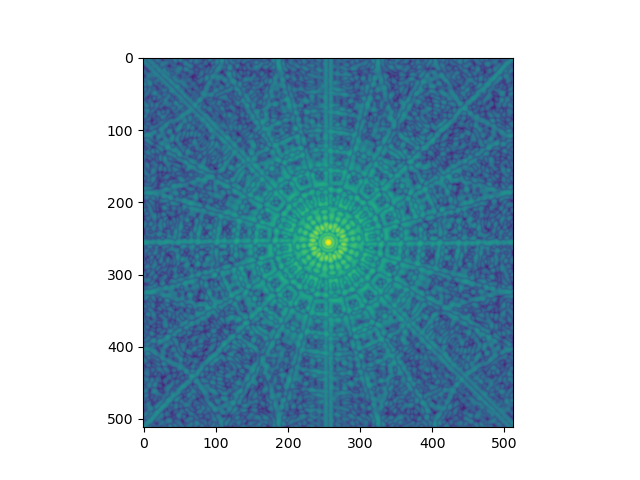

In [3]:
# Test on a simulated pattern (2D)
n = 512

# Siemens-Star object
obj0 = siemens_star(n, nb_rays=12, r_max=60, nb_rings=3)

# Simulated iobs
iobs = abs(ifftshift(fft2(fftshift(obj0.astype(np.complex64))))) ** 2

# Convolve with Gaussian kernel
iobs = gaussian_filter(input=iobs, sigma=(0.7,0.7))

# Add Poisson noise
iobs = np.random.poisson(iobs * 1e10 / iobs.sum())
plt.imshow(np.log10(iobs))

In [34]:
# Start from a slightly loose disc support
x, y = np.meshgrid(np.arange(-n // 2, n // 2, dtype=np.float32), np.arange(-n // 2, n // 2, dtype=np.float32))
r = np.sqrt(x ** 2 + y ** 2)
support = r < 65

mask = np.zeros_like(iobs, dtype=np.int16)
if False:
    # Mask some values in the central beam (much more difficult)
    print("Removing %6.3f%% intensity" % (iobs[255:257, 255:257].sum() / iobs.sum() * 100))
    iobs[255:257, 255:257] = 0
    mask[255:257, 255:257] = 1

cdi = CDI(fftshift(iobs), obj=None, support=fftshift(support), mask=fftshift(mask), wavelength=1e-10,
          pixel_size_detector=55e-10)

# Init real object from the chosen support
cdi = InitObjRandom(src="support", amin=0, amax=1, phirange=0) * cdi

# Initial scaling of the object [ only useful if there are masked pixels !]
cdi = ScaleObj(method='F') * cdi

 HIO #  0 LLK= 61812.859[free=  0.000](p), nb photons=5.968318e+09, support:nb= 13237 ( 5.050%) <obj>=    671.48 max=   2934.51, out=24.183% dt/cycle=0.6646s 
 HIO # 50 LLK= 25151.691[free=  0.000](p), nb photons=1.208081e+10, support:nb= 13237 ( 5.050%) <obj>=    955.33 max=   2855.91, out=8.007% dt/cycle=0.0009s 
LLK_n = 13143.798


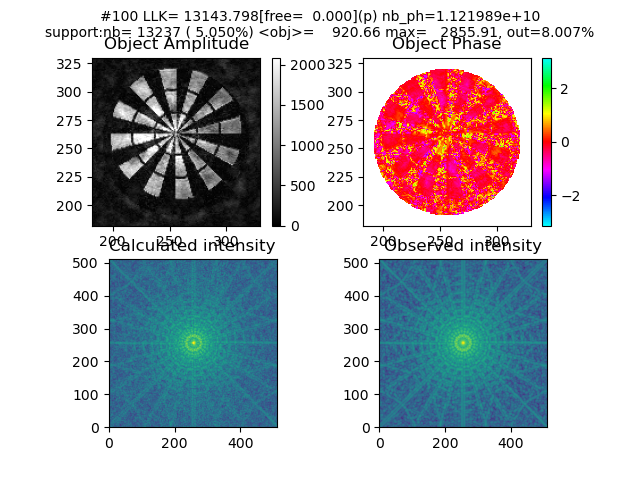

In [35]:
# Do 100 cycles of RAAR
cdi = HIO(positivity=True, calc_llk=50, show_cdi=50) ** 100 * cdi

# Compute LLK
LLK() * cdi
print("LLK_n = %8.3f" % (cdi.get_llk(noise='poisson')))

cdi = ShowCDI() * cdi

In [36]:
sup = SupportUpdate(threshold_relative=0.4, smooth_width=(2.0, 0.5, 800), force_shrink=False)

cdi = (sup * ER(positivity=True, calc_llk=40, show_cdi=40) ** 5 * 
       HIO(positivity=True,calc_llk=40, show_cdi=40) ** 40) ** 5 * cdi


 HIO #120 LLK= 13484.442[free=  0.000](p), nb photons=1.127009e+10, support:nb= 13237 ( 5.050%) <obj>=    922.72 max=   2746.17, out=2.253% dt/cycle=0.0487s 
 HIO #160 LLK= 8375.958[free=  0.000](p), nb photons=1.055987e+10, support:nb=  7267 ( 2.772%) <obj>=   1205.46 max=   2649.32, out=2.832% dt/cycle=0.0010s 
 HIO #200 LLK= 6898.376[free=  0.000](p), nb photons=1.042572e+10, support:nb=  6346 ( 2.421%) <obj>=   1281.75 max=   2622.54, out=2.411% dt/cycle=0.0009s 
 HIO #240 LLK= 4442.514[free=  0.000](p), nb photons=1.017685e+10, support:nb=  6066 ( 2.314%) <obj>=   1295.26 max=   2616.31, out=1.711% dt/cycle=0.0008s 
 HIO #280 LLK= 461.935[free=  0.000](p), nb photons=9.949168e+09, support:nb=  5908 ( 2.254%) <obj>=   1297.70 max=   2621.13, out=0.685% dt/cycle=0.0007s 
  ER #320 LLK= 15535.059[free=  0.000](p), nb photons=1.147521e+10, support:nb=  5908 ( 2.254%) <obj>=   1393.67 max=   2610.88, out=4.594% dt/cycle=0.0056s 


In [37]:
# Now Estimate the PSF and update it regularly
cdi = InitPSF(model="gaussian", fwhm=0.5) * cdi


sup = SupportUpdate(threshold_relative=0.35, smooth_width=(1.0, 0.5, 800), force_shrink=False)
er = ER(positivity=True, calc_llk=40, show_cdi=40, update_psf=20)
raar = RAAR(positivity=True, calc_llk=40, show_cdi=40, update_psf=20)
hio = HIO(positivity=True, calc_llk=40, show_cdi=40, update_psf=20)

cdi = (sup * er ** 5 * hio ** 40) ** 5 * cdi


 HIO #360 LLK= 29719.771[free=  0.000](p), nb photons=1.428228e+10, support:nb=  5791 ( 2.209%) <obj>=   1570.44 max=   2614.28, out=5.928% dt/cycle=0.0413s [PSF]
 HIO #400 LLK= 20680.164[free=  0.000](p), nb photons=1.238782e+10, support:nb=  5517 ( 2.105%) <obj>=   1498.46 max=   2601.75, out=5.386% dt/cycle=0.0012s [PSF]
 HIO #440 LLK= 53280.090[free=  0.000](p), nb photons=1.621912e+10, support:nb=  5394 ( 2.058%) <obj>=   1734.04 max=   2587.76, out=12.108% dt/cycle=0.0011s [PSF]
 HIO #480 LLK= 53760.807[free=  0.000](p), nb photons=1.460412e+10, support:nb=  5333 ( 2.034%) <obj>=   1654.82 max=   2582.84, out=14.073% dt/cycle=0.0013s [PSF]
 HIO #520 LLK= 113591.184[free=  0.000](p), nb photons=1.905154e+10, support:nb=  5315 ( 2.028%) <obj>=   1893.27 max=   2518.23, out=18.247% dt/cycle=0.0009s [PSF]


In [ ]:
# Release GPU memory
cdi = FreePU() * cdi